In [107]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from os.path import join as pjoin

import matplotlib.pyplot as plt
import cv2 as cv
from skimage.io import imshow, imread, imsave

import warnings
warnings.filterwarnings('ignore')

work_dir = './data'
file_path = './data/faces/'
label_data = './data/labels.csv'

In [108]:
files = os.listdir(file_path)
files.sort()
f_names = pd.Series(files, dtype=str)

In [109]:
labels = pd.read_csv(label_data)

In [110]:
labels.head()

,is_smile,yaw,pitch,roll
0,1,-0.021162,0.059530,-0.039662
1,1,-0.057745,0.083098,-0.094952
2,1,0.095993,0.028798,0.065996
3,1,0.000000,0.047124,0.171268
4,1,0.036073,0.043633,-0.181721


In [111]:
data = pd.DataFrame()#index=f_names)
data['file_name'] = f_names
for key in labels:
    data[key] = labels[key]

In [112]:
data.head()

,file_name,is_smile,yaw,pitch,roll
0,file0001.jpg,1,-0.021162,0.059530,-0.039662
1,file0002.jpg,1,-0.057745,0.083098,-0.094952
2,file0003.jpg,1,0.095993,0.028798,0.065996
3,file0004.jpg,1,0.000000,0.047124,0.171268
4,file0005.jpg,1,0.036073,0.043633,-0.181721


In [115]:
data['path'] = file_path + data['file_name']

In [117]:
data.to_csv('./data/face_index.csv', index=False)

## capture mouthes and save them

In [47]:
import cv2 as cv
from skimage.io import imshow, imread, imsave

In [48]:
# load classifiers
harr_face = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
harr_mouth = cv.CascadeClassifier('haarcascade_mouth.xml')

# FACE: find the largest detected face as detected face
def find_max_square(squares, tag='square', verbose=0):
    max_square_size = 0
    max_square = []
    if len(squares) > 0:
        # squares: [0]: x; [1]: y; [2]: width; [3]: height
        for (x, y, w, h) in squares:
            if  w * h > max_square_size:
                max_square_size = w * h
                max_square = [x, y, w, h]

        if verbose > 0:
            if len(max_square) == 0: # did not detect face
                print('no %s found')# in %s' % (tag, img_path))
            else:
                print('find %s @ %s' % (tag, str(max_square)))
    return max_square

def find_lowest_square(squares, tag='square', verbose=0):
    max_y = 0
    lowest_square = []
    if len(squares) > 0:
        # squares: [0]: x; [1]: y; [2]: width; [3]: height
        for (x, y, w, h) in squares:
            if  y > max_y:
                max_y = y
                lowest_square = [x, y, w, h]

        if verbose > 0:
            if len(lowest_square) == 0: # did not detect face
                print('no %s found in')# %s' % (tag, img_path))
            else:
                print('find %s @ %s' % (tag, str(lowest_square)))
                
    return lowest_square

def find_mouth(img, is_square_face=False, is_square_mouth=False):
    # runing the classifiers
#     img = imread(img_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = harr_face.detectMultiScale(gray, 1.3, 5)
    max_face = find_max_square(faces, tag='face')
    # for (x, y, w, h) in faces:
    # img = cv.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    if len(max_face) > 0:
        x, y, w, h = max_face
        face_gray = gray[y:y+h, x:x+w]
        face_color = img[y:y+h, x:x+w]
        if is_square_face:
            cv.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    #     imshow(img)
        mouths = harr_mouth.detectMultiScale(face_gray)
        mouth = find_lowest_square(mouths, tag='mouth')
    #     for (mx, my, mw, mh) in mouths:
    #         cv.rectangle(roi_color, (mx,my), (mx+mw, my+mh), (0,255,0), 1)
    #         print(mx, my, mw, mh)
        if len(mouth) > 0:
            mx, my, mw, mh = mouth
            if is_square_mouth:
                cv.rectangle(face_color, (mx,my), (mx+mw, my+mh), (0,255,0), 1)
#             imshow(img)
            return x+mx, y+my, mw, mh
    return []

def img_generator(data):
    for i in range(len(data)):
        im_info = data.loc[i]
        path = os.path.join(file_path, im_info.file_name)
        yield path, im_info.is_smile

def get_partial(img, x, y, w, h):
    return img[y:y+h, x:x+w]

def check_creat_dir(save_path):
    dir_path = os.path.dirname(save_path)
    if not os.path.exists(dir_path):
        print('create folder... %s' % dir_path)
        os.makedirs(dir_path)

In [49]:
def capture_mouth(img_path, is_smile, verbos=1):
    mouth_path = 'mouths'
    mouth_path_smile = 'smile'
    mouth_path_notsmile = 'notsmile'

#     img_path, is_smile = next(img_gen)

    img = imread(img_path)
    img = img.copy()
    mouth = find_mouth(img=img)

    if len(mouth) > 0:
        if verbos>0:
            print('find %s mouth in %s' % ('smile' if is_smile==1 else 'neutral', img_path))
        x, y, w, h = mouth
        mouth_img = get_partial(img, x, y, w, h)
        mouth_file_name = os.path.basename(img_path).replace('file', 'mouth')
        if is_smile == 1:
            save_path = os.path.join(work_dir, mouth_path, 
                                     mouth_path_smile, mouth_file_name)
        else:
            save_path = os.path.join(work_dir, mouth_path, 
                                     mouth_path_notsmile, mouth_file_name)
        if verbos>0:
            print('save img...')
        check_creat_dir(save_path)
        imsave(save_path, mouth_img)
#         cv.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)
        check_creat_dir(img_path.replace('faces', 'tag_face'))
        imsave(img_path.replace('faces', 'tag_face'), img)
    else:
        if verbos>0:
            print('No mouth found in %s' % img_path)

In [50]:
img_gen = img_generator(data)

In [51]:
for img_path, is_smile in img_gen:
    try:
        capture_mouth(img_path, is_smile, verbos=0)
    except:
        print(f"error found for {img_path}")

create folder... ./mouths/smile
create folder... ./tag_face
create folder... ./mouths/notsmile
error found for ./faces/file2346.jpg
error found for ./faces/file3975.jpg


## from mouth & faces generate csv

In [52]:
# ip, sm = next(img_gen)
# capture_mouth(ip, sm)

In [53]:
tag_face_dir = pjoin(work_dir, 'tag_face')
smile_mouth_dir = pjoin(work_dir, 'mouths', 'smile')
notsmile_mouth_dir = pjoin(work_dir, 'mouths', 'notsmile')
faces = os.listdir(tag_face_dir)
smile_mouths = os.listdir(smile_mouth_dir)
notsmile_mouths = os.listdir(notsmile_mouth_dir)

In [54]:
pd_face = pd.DataFrame()
pd_sm = pd.DataFrame()
pd_nsm = pd.DataFrame()

In [55]:
pd_face['path']=[pjoin(tag_face_dir, x) for x in faces]
pd_sm['mpath']=[pjoin(smile_mouth_dir, x) for x in smile_mouths]
pd_nsm['mpath']=[pjoin(notsmile_mouth_dir, x) for x in notsmile_mouths]

In [56]:
pd_face['index'] = pd_face['path'].apply(lambda x: os.path.basename(x).replace('file', '').replace('.jpg', ''))
pd_sm['index'] = pd_sm['mpath'].apply(lambda x: os.path.basename(x).replace('mouth', '').replace('.jpg', ''))
pd_nsm['index'] = pd_nsm['mpath'].apply(lambda x: os.path.basename(x).replace('mouth', '').replace('.jpg', ''))

In [57]:
pd_face.set_index('index', inplace=True)
pd_sm.set_index('index', inplace=True)
pd_nsm.set_index('index', inplace=True)

In [58]:
pd_face = pd_face.join(pd_sm.append(pd_nsm), how='left')

In [59]:
pd_face = pd_face.sort_index()

In [60]:
pd_face['is_smile'] = pd_face['mpath'].apply(lambda x: 0 if 'notsmile' in x else 1)

#### save data

In [61]:
pd_face.to_csv('./data/face_mouth_data_index.csv', sep=',', quotechar='"')

In [62]:
shapes = []
for x in pd_face.mpath.values:
    img = imread(x)
    x, y, z = img.shape
    shapes.append([x, y, z])
shapes = np.array(shapes)
shapes = pd.DataFrame(shapes, columns=['x', 'y', 'z'])

In [63]:
shapes.describe()

,x,y,z
count,3221.000000,3221.000000,3221.0
mean,24.527476,41.040671,3.0
std,4.828256,8.012561,0.0
min,15.000000,25.000000,3.0
25%,21.000000,35.000000,3.0
50%,24.000000,41.000000,3.0
75%,28.000000,46.000000,3.0
max,44.000000,74.000000,3.0


## pre-process mouth img. normalize

In [64]:
from PIL import Image
WIDTH, HEIGHT = 48, 28 # all mouth images will be resized to the same size
dim = WIDTH * HEIGHT # dimension of feature vector

In [65]:
def normalize_img(filename, is_grey=True, is_vectorize=False):
    size = WIDTH, HEIGHT # (width, height)
    im = Image.open(filename) 
    resized_im = im.resize(size, Image.ANTIALIAS) # resize image
    result = np.array(resized_im)
    if is_grey:
        im_grey = resized_im.convert('L') # convert the image to *greyscale*
        im_array = np.array(im_grey) # convert to np array
        result = im_array
    if is_vectorize:
        oned_array = result.reshape(size[0] * size[1])
        result = oned_array
    return result#np.array(resized_im)#oned_array

In [66]:
imgs = []
for i_index in range(len(pd_face)):
    img = normalize_img(pd_face.iloc[i_index].mpath, is_grey=True, is_vectorize=True)#False)
    imgs.append(img)
#     imshow(img)
#     print(pd_face.iloc[i_index])
imgs = np.array(imgs)

In [67]:
pd_mouth_data = pd.DataFrame(imgs)

In [68]:
# pd_mouth_data = pd_face.reset_index().join(pd_imgs_data, how='left')

In [69]:
pd_mouth_data.to_csv('./data/face_mouth_data.csv', sep=',', quotechar='"')

## train model

In [70]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import normalize

In [71]:
data_img_vec = pd_mouth_data.values

In [72]:
data_img_vec = pd.read_csv('./data/face_mouth_data.csv', index_col=0)

In [73]:
pd_face = pd.read_csv('./data/face_mouth_data_index.csv', index_col=0)

In [74]:
pd_face.head()

,path,mpath,is_smile
index,,,
1,./tag_face/file0001.jpg,./mouths/smile/mouth0001.jpg,1
2,./tag_face/file0002.jpg,./mouths/smile/mouth0002.jpg,1
3,./tag_face/file0003.jpg,./mouths/smile/mouth0003.jpg,1
4,./tag_face/file0004.jpg,./mouths/smile/mouth0004.jpg,1
5,./tag_face/file0005.jpg,./mouths/smile/mouth0005.jpg,1


In [75]:
data_img_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
0,131,131,133,138,143,144,139,136,138,146,...,142,137,135,134,134,133,134,135,137,139
1,64,69,76,80,79,71,61,56,55,59,...,75,78,80,78,73,70,69,71,73,73
2,104,106,111,115,118,118,115,113,110,107,...,73,66,57,49,43,40,38,39,41,42
3,153,151,148,145,146,148,150,150,147,145,...,141,145,150,155,158,160,160,157,155,154
4,210,210,210,212,215,217,219,219,214,210,...,220,217,216,218,220,222,221,220,218,216


In [77]:
data_img_vec_norm = data_img_vec / 255 #normalize(data_img_vec, norm='l2', axis=0)

In [78]:
data_img_vec_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
0,0.513725,0.513725,0.521569,0.541176,0.560784,0.564706,0.545098,0.533333,0.541176,0.572549,...,0.556863,0.537255,0.529412,0.525490,0.525490,0.521569,0.525490,0.529412,0.537255,0.545098
1,0.250980,0.270588,0.298039,0.313725,0.309804,0.278431,0.239216,0.219608,0.215686,0.231373,...,0.294118,0.305882,0.313725,0.305882,0.286275,0.274510,0.270588,0.278431,0.286275,0.286275
2,0.407843,0.415686,0.435294,0.450980,0.462745,0.462745,0.450980,0.443137,0.431373,0.419608,...,0.286275,0.258824,0.223529,0.192157,0.168627,0.156863,0.149020,0.152941,0.160784,0.164706
3,0.600000,0.592157,0.580392,0.568627,0.572549,0.580392,0.588235,0.588235,0.576471,0.568627,...,0.552941,0.568627,0.588235,0.607843,0.619608,0.627451,0.627451,0.615686,0.607843,0.603922
4,0.823529,0.823529,0.823529,0.831373,0.843137,0.850980,0.858824,0.858824,0.839216,0.823529,...,0.862745,0.850980,0.847059,0.854902,0.862745,0.870588,0.866667,0.862745,0.854902,0.847059


In [79]:
data_imgs = data_img_vec_norm.values.reshape(-1, HEIGHT, WIDTH, 1)

In [80]:
pd_face['is_smile'].value_counts()

1    1808
0    1413
Name: is_smile, dtype: int64

In [81]:
data_labels = to_categorical(pd_face['is_smile'].values, num_classes=2)

In [82]:
data_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [106]:
data_imgs.shape

(3221, 28, 48, 1)

In [91]:
random_seed = 5012
X_train, X_val, Y_train, Y_val = train_test_split(data_imgs, data_labels, test_size=0.1, random_state=random_seed)

In [98]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',
                activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same',
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(2,2), padding='Same',
                activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(2,2), padding='Same',
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))#, kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [99]:
# define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 48, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 48, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 48, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 48, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 24, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 24, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 24, 64)        8256      
__________

In [100]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)
datagen.fit(X_train)

In [101]:
# set a early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)
epochs = 30
batch_size = 170

In [102]:
# # without data augmentation
# history = model.fit(X_train, Y_train, batch_size=batch_size,
#                     epochs=epochs, validation_data=(X_val, Y_val), verbose=2)
# with data augmentation
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                              epochs=epochs, 
                              validation_data=(X_val, Y_val), 
                              verbose=2, 
#                               steps_per_epoch=X_train[0], 
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 22s - loss: 4.5759 - acc: 0.6610 - val_loss: 4.0299 - val_acc: 0.7307
Epoch 2/30
 - 20s - loss: 3.1031 - acc: 0.7836 - val_loss: 3.1100 - val_acc: 0.7895
Epoch 3/30
 - 20s - loss: 3.0086 - acc: 0.7918 - val_loss: 2.7689 - val_acc: 0.8050
Epoch 4/30
 - 20s - loss: 2.8770 - acc: 0.7928 - val_loss: 2.7159 - val_acc: 0.8173
Epoch 5/30
 - 21s - loss: 2.5110 - acc: 0.8266 - val_loss: 2.2640 - val_acc: 0.8483
Epoch 6/30
 - 21s - loss: 2.9690 - acc: 0.7898 - val_loss: 4.0296 - val_acc: 0.7214
Epoch 7/30
 - 20s - loss: 2.3957 - acc: 0.8394 - val_loss: 2.1857 - val_acc: 0.8483
Epoch 8/30
 - 20s - loss: 2.1724 - acc: 0.8577 - val_loss: 3.3139 - val_acc: 0.7616

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
 - 20s - loss: 2.3525 - acc: 0.8412 - val_loss: 2.4058 - val_acc: 0.8390
Epoch 10/30
 - 19s - loss: 1.9569 - acc: 0.8673 - val_loss: 1.8145 - val_acc: 0.8421
Epoch 11/30
 - 19s - loss: 2.0753 - acc: 0.8571 - val_loss: 1.9598 - val_acc: 

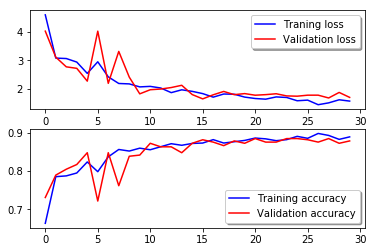

In [103]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Traning loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)
fig.show()

In [104]:
model.save('./model/model_smile_rec_by_nn.h5')

## other approches attemps

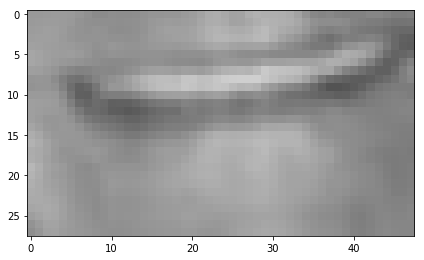

In [292]:
index = 800
t = data_img_vec[index].copy()
t.shape
imshow(t.reshape(HEIGHT, WIDTH))

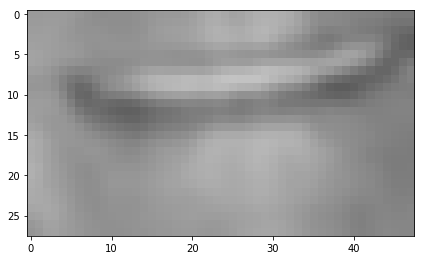

In [293]:
im_t = t.reshape(HEIGHT, WIDTH)
img = cv.GaussianBlur(im_t,(3,3),0)
imshow(img)

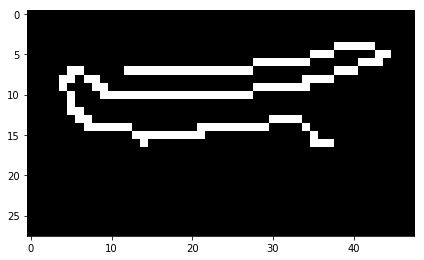

In [294]:
imshow(cv.Canny(img, 50, 150))

In [269]:
t.shape

(1344,)

In [132]:
t_vec = normalize(t.reshape(10, 28), norm='l2', axis=1).reshape(-1,10,28,1)

In [134]:
t_vec.shape

(1, 10, 28, 1)

In [107]:
result = model.predict(t_vec)

In [108]:
result[0][1]

0.9808818

In [155]:
Image.open('./data/mouths/smile/mouth0002.jpg')

In [182]:
Image.open('./data/mouths/smile/mouth0002.jpg').resize((48, 28), Image.ANTIALIAS) # resize image